In [1]:
import json

try:
    with open('alpaca_data.json', 'r') as file:
        data = json.load(file)
        # Process the data
except FileNotFoundError:
    print("Error: File not found.")
except json.JSONDecodeError:
    print("Error: Invalid JSON format.")

In [2]:
print(data[0])

{'instruction': 'Give three tips for staying healthy.', 'input': '', 'output': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.'}


In [3]:
print(data[111])

{'instruction': 'What type of punctuation should be used at the end of the following sentence?', 'input': "Let's look at the bird", 'output': 'A question mark (?) should be used at the end of the sentence.'}


In [4]:
print(data[50])

{'instruction': 'Edit the following sentence to make it more concise.', 'input': 'He ran to the bus stop in order to catch the bus that was due to arrive in five minutes.', 'output': 'He ran to the bus stop, due to arrive in five minutes.'}


In [5]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [6]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Edit the following sentence to make it more concise.

### Input:
He ran to the bus stop in order to catch the bus that was due to arrive in five minutes.

### Response:
He ran to the bus stop, due to arrive in five minutes.


In [7]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Describe the flavor profile of the following type of cuisine

### Input:
Japanese

### Response:
Japanese cuisine is characterized by its subtle and delicate flavors, featuring a combination of salty, sweet, sour, and umami flavors. It also utilizes fresh ingredients with a focus on preserving their natural flavors.


In [8]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [9]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 44201
Validation set length: 2601
Test set length: 5200


In [10]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

C:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [12]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [13]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [14]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [15]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_draft_2(batch)
print("inputs:\n",inputs)
print("targets:\n",targets)


inputs:
 tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
targets:
 tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [16]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [17]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [18]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [19]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [20]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)

targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is much faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")

print("Device:", device)

Device: cpu


In [22]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [23]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [24]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 163]) torch.Size([8, 163])
torch.Size([8, 300]) torch.Size([8, 300])
torch.Size([8, 209]) torch.Size([8, 209])
torch.Size([8, 167]) torch.Size([8, 167])
torch.Size([8, 123]) torch.Size([8, 123])
torch.Size([8, 145]) torch.Size([8, 145])
torch.Size([8, 173]) torch.Size([8, 173])
torch.Size([8, 262]) torch.Size([8, 262])
torch.Size([8, 194]) torch.Size([8, 194])
torch.Size([8, 327]) torch.Size([8, 327])
torch.Size([8, 132]) torch.Size([8, 132])
torch.Size([8, 141]) torch.Size([8, 141])
torch.Size([8, 186]) torch.Size([8, 186])
torch.Size([8, 200]) torch.Size([8, 200])
torch.Size([8, 217]) torch.Size([8, 217])
torch.Size([8, 159]) torch.Size([8, 159])
torch.Size([8, 121]) torch.Size([8, 121])
torch.Size([8, 188]) torch.Size([8, 188])
torch.Size([8, 157]) torch.Size([8, 157])
torch.Size([8, 133]) torch.Size([8, 133])
torch.Size([8, 133]) torch.Size([8, 133])
torch.Size([8, 143]) torch.Size([8, 143])
torch.Size([8, 223]) torch.Size([8, 223])
torch.Size([8, 162])

torch.Size([8, 125]) torch.Size([8, 125])
torch.Size([8, 165]) torch.Size([8, 165])
torch.Size([8, 188]) torch.Size([8, 188])
torch.Size([8, 136]) torch.Size([8, 136])
torch.Size([8, 130]) torch.Size([8, 130])
torch.Size([8, 172]) torch.Size([8, 172])
torch.Size([8, 195]) torch.Size([8, 195])
torch.Size([8, 316]) torch.Size([8, 316])
torch.Size([8, 156]) torch.Size([8, 156])
torch.Size([8, 176]) torch.Size([8, 176])
torch.Size([8, 138]) torch.Size([8, 138])
torch.Size([8, 298]) torch.Size([8, 298])
torch.Size([8, 166]) torch.Size([8, 166])
torch.Size([8, 235]) torch.Size([8, 235])
torch.Size([8, 121]) torch.Size([8, 121])
torch.Size([8, 297]) torch.Size([8, 297])
torch.Size([8, 137]) torch.Size([8, 137])
torch.Size([8, 225]) torch.Size([8, 225])
torch.Size([8, 130]) torch.Size([8, 130])
torch.Size([8, 142]) torch.Size([8, 142])
torch.Size([8, 189]) torch.Size([8, 189])
torch.Size([8, 180]) torch.Size([8, 180])
torch.Size([8, 158]) torch.Size([8, 158])
torch.Size([8, 148]) torch.Size([8

torch.Size([8, 137]) torch.Size([8, 137])
torch.Size([8, 242]) torch.Size([8, 242])
torch.Size([8, 297]) torch.Size([8, 297])
torch.Size([8, 241]) torch.Size([8, 241])
torch.Size([8, 131]) torch.Size([8, 131])
torch.Size([8, 205]) torch.Size([8, 205])
torch.Size([8, 122]) torch.Size([8, 122])
torch.Size([8, 158]) torch.Size([8, 158])
torch.Size([8, 207]) torch.Size([8, 207])
torch.Size([8, 172]) torch.Size([8, 172])
torch.Size([8, 134]) torch.Size([8, 134])
torch.Size([8, 200]) torch.Size([8, 200])
torch.Size([8, 251]) torch.Size([8, 251])
torch.Size([8, 402]) torch.Size([8, 402])
torch.Size([8, 233]) torch.Size([8, 233])
torch.Size([8, 152]) torch.Size([8, 152])
torch.Size([8, 144]) torch.Size([8, 144])
torch.Size([8, 173]) torch.Size([8, 173])
torch.Size([8, 171]) torch.Size([8, 171])
torch.Size([8, 275]) torch.Size([8, 275])
torch.Size([8, 243]) torch.Size([8, 243])
torch.Size([8, 130]) torch.Size([8, 130])
torch.Size([8, 149]) torch.Size([8, 149])
torch.Size([8, 109]) torch.Size([8

torch.Size([8, 173]) torch.Size([8, 173])
torch.Size([8, 234]) torch.Size([8, 234])
torch.Size([8, 376]) torch.Size([8, 376])
torch.Size([8, 282]) torch.Size([8, 282])
torch.Size([8, 231]) torch.Size([8, 231])
torch.Size([8, 247]) torch.Size([8, 247])
torch.Size([8, 393]) torch.Size([8, 393])
torch.Size([8, 154]) torch.Size([8, 154])
torch.Size([8, 178]) torch.Size([8, 178])
torch.Size([8, 197]) torch.Size([8, 197])
torch.Size([8, 127]) torch.Size([8, 127])
torch.Size([8, 182]) torch.Size([8, 182])
torch.Size([8, 190]) torch.Size([8, 190])
torch.Size([8, 247]) torch.Size([8, 247])
torch.Size([8, 218]) torch.Size([8, 218])
torch.Size([8, 284]) torch.Size([8, 284])
torch.Size([8, 122]) torch.Size([8, 122])
torch.Size([8, 180]) torch.Size([8, 180])
torch.Size([8, 271]) torch.Size([8, 271])
torch.Size([8, 183]) torch.Size([8, 183])
torch.Size([8, 419]) torch.Size([8, 419])
torch.Size([8, 201]) torch.Size([8, 201])
torch.Size([8, 267]) torch.Size([8, 267])
torch.Size([8, 227]) torch.Size([8

torch.Size([8, 514]) torch.Size([8, 514])
torch.Size([8, 179]) torch.Size([8, 179])
torch.Size([8, 185]) torch.Size([8, 185])
torch.Size([8, 342]) torch.Size([8, 342])
torch.Size([8, 189]) torch.Size([8, 189])
torch.Size([8, 194]) torch.Size([8, 194])
torch.Size([8, 140]) torch.Size([8, 140])
torch.Size([8, 171]) torch.Size([8, 171])
torch.Size([8, 186]) torch.Size([8, 186])
torch.Size([8, 195]) torch.Size([8, 195])
torch.Size([8, 178]) torch.Size([8, 178])
torch.Size([8, 125]) torch.Size([8, 125])
torch.Size([8, 150]) torch.Size([8, 150])
torch.Size([8, 202]) torch.Size([8, 202])
torch.Size([8, 194]) torch.Size([8, 194])
torch.Size([8, 224]) torch.Size([8, 224])
torch.Size([8, 239]) torch.Size([8, 239])
torch.Size([8, 147]) torch.Size([8, 147])
torch.Size([8, 229]) torch.Size([8, 229])
torch.Size([8, 192]) torch.Size([8, 192])
torch.Size([8, 140]) torch.Size([8, 140])
torch.Size([8, 121]) torch.Size([8, 121])
torch.Size([8, 221]) torch.Size([8, 221])
torch.Size([8, 141]) torch.Size([8

torch.Size([8, 420]) torch.Size([8, 420])
torch.Size([8, 205]) torch.Size([8, 205])
torch.Size([8, 166]) torch.Size([8, 166])
torch.Size([8, 129]) torch.Size([8, 129])
torch.Size([8, 315]) torch.Size([8, 315])
torch.Size([8, 133]) torch.Size([8, 133])
torch.Size([8, 90]) torch.Size([8, 90])
torch.Size([8, 157]) torch.Size([8, 157])
torch.Size([8, 223]) torch.Size([8, 223])
torch.Size([8, 176]) torch.Size([8, 176])
torch.Size([8, 140]) torch.Size([8, 140])
torch.Size([8, 226]) torch.Size([8, 226])
torch.Size([8, 161]) torch.Size([8, 161])
torch.Size([8, 201]) torch.Size([8, 201])
torch.Size([8, 134]) torch.Size([8, 134])
torch.Size([8, 156]) torch.Size([8, 156])
torch.Size([8, 280]) torch.Size([8, 280])
torch.Size([8, 149]) torch.Size([8, 149])
torch.Size([8, 193]) torch.Size([8, 193])
torch.Size([8, 136]) torch.Size([8, 136])
torch.Size([8, 210]) torch.Size([8, 210])
torch.Size([8, 129]) torch.Size([8, 129])
torch.Size([8, 194]) torch.Size([8, 194])
torch.Size([8, 195]) torch.Size([8, 

torch.Size([8, 228]) torch.Size([8, 228])
torch.Size([8, 217]) torch.Size([8, 217])
torch.Size([8, 226]) torch.Size([8, 226])
torch.Size([8, 141]) torch.Size([8, 141])
torch.Size([8, 424]) torch.Size([8, 424])
torch.Size([8, 194]) torch.Size([8, 194])
torch.Size([8, 131]) torch.Size([8, 131])
torch.Size([8, 172]) torch.Size([8, 172])
torch.Size([8, 190]) torch.Size([8, 190])
torch.Size([8, 185]) torch.Size([8, 185])
torch.Size([8, 123]) torch.Size([8, 123])
torch.Size([8, 188]) torch.Size([8, 188])
torch.Size([8, 181]) torch.Size([8, 181])
torch.Size([8, 179]) torch.Size([8, 179])
torch.Size([8, 266]) torch.Size([8, 266])
torch.Size([8, 297]) torch.Size([8, 297])
torch.Size([8, 304]) torch.Size([8, 304])
torch.Size([8, 147]) torch.Size([8, 147])
torch.Size([8, 251]) torch.Size([8, 251])
torch.Size([8, 166]) torch.Size([8, 166])
torch.Size([8, 154]) torch.Size([8, 154])
torch.Size([8, 148]) torch.Size([8, 148])
torch.Size([8, 211]) torch.Size([8, 211])
torch.Size([8, 230]) torch.Size([8

torch.Size([8, 130]) torch.Size([8, 130])
torch.Size([8, 195]) torch.Size([8, 195])
torch.Size([8, 181]) torch.Size([8, 181])
torch.Size([8, 485]) torch.Size([8, 485])
torch.Size([8, 263]) torch.Size([8, 263])
torch.Size([8, 150]) torch.Size([8, 150])
torch.Size([8, 212]) torch.Size([8, 212])
torch.Size([8, 225]) torch.Size([8, 225])
torch.Size([8, 188]) torch.Size([8, 188])
torch.Size([8, 188]) torch.Size([8, 188])
torch.Size([8, 239]) torch.Size([8, 239])
torch.Size([8, 286]) torch.Size([8, 286])
torch.Size([8, 172]) torch.Size([8, 172])
torch.Size([8, 206]) torch.Size([8, 206])
torch.Size([8, 156]) torch.Size([8, 156])
torch.Size([8, 171]) torch.Size([8, 171])
torch.Size([8, 181]) torch.Size([8, 181])
torch.Size([8, 170]) torch.Size([8, 170])
torch.Size([8, 145]) torch.Size([8, 145])
torch.Size([8, 89]) torch.Size([8, 89])
torch.Size([8, 257]) torch.Size([8, 257])
torch.Size([8, 178]) torch.Size([8, 178])
torch.Size([8, 172]) torch.Size([8, 172])
torch.Size([8, 149]) torch.Size([8, 

torch.Size([8, 160]) torch.Size([8, 160])
torch.Size([8, 227]) torch.Size([8, 227])
torch.Size([8, 161]) torch.Size([8, 161])
torch.Size([8, 177]) torch.Size([8, 177])
torch.Size([8, 184]) torch.Size([8, 184])
torch.Size([8, 157]) torch.Size([8, 157])
torch.Size([8, 175]) torch.Size([8, 175])
torch.Size([8, 188]) torch.Size([8, 188])
torch.Size([8, 181]) torch.Size([8, 181])
torch.Size([8, 151]) torch.Size([8, 151])
torch.Size([8, 132]) torch.Size([8, 132])
torch.Size([8, 137]) torch.Size([8, 137])
torch.Size([8, 164]) torch.Size([8, 164])
torch.Size([8, 116]) torch.Size([8, 116])
torch.Size([8, 158]) torch.Size([8, 158])
torch.Size([8, 120]) torch.Size([8, 120])
torch.Size([8, 156]) torch.Size([8, 156])
torch.Size([8, 120]) torch.Size([8, 120])
torch.Size([8, 164]) torch.Size([8, 164])
torch.Size([8, 184]) torch.Size([8, 184])
torch.Size([8, 141]) torch.Size([8, 141])
torch.Size([8, 135]) torch.Size([8, 135])
torch.Size([8, 174]) torch.Size([8, 174])
torch.Size([8, 196]) torch.Size([8

torch.Size([8, 375]) torch.Size([8, 375])
torch.Size([8, 154]) torch.Size([8, 154])
torch.Size([8, 166]) torch.Size([8, 166])
torch.Size([8, 181]) torch.Size([8, 181])
torch.Size([8, 186]) torch.Size([8, 186])
torch.Size([8, 260]) torch.Size([8, 260])
torch.Size([8, 226]) torch.Size([8, 226])
torch.Size([8, 201]) torch.Size([8, 201])
torch.Size([8, 186]) torch.Size([8, 186])
torch.Size([8, 168]) torch.Size([8, 168])
torch.Size([8, 172]) torch.Size([8, 172])
torch.Size([8, 147]) torch.Size([8, 147])
torch.Size([8, 293]) torch.Size([8, 293])
torch.Size([8, 182]) torch.Size([8, 182])
torch.Size([8, 210]) torch.Size([8, 210])
torch.Size([8, 203]) torch.Size([8, 203])
torch.Size([8, 198]) torch.Size([8, 198])
torch.Size([8, 243]) torch.Size([8, 243])
torch.Size([8, 255]) torch.Size([8, 255])
torch.Size([8, 155]) torch.Size([8, 155])
torch.Size([8, 119]) torch.Size([8, 119])
torch.Size([8, 174]) torch.Size([8, 174])
torch.Size([8, 201]) torch.Size([8, 201])
torch.Size([8, 251]) torch.Size([8

torch.Size([8, 197]) torch.Size([8, 197])
torch.Size([8, 151]) torch.Size([8, 151])
torch.Size([8, 273]) torch.Size([8, 273])
torch.Size([8, 168]) torch.Size([8, 168])
torch.Size([8, 229]) torch.Size([8, 229])
torch.Size([8, 144]) torch.Size([8, 144])
torch.Size([8, 560]) torch.Size([8, 560])
torch.Size([8, 350]) torch.Size([8, 350])
torch.Size([8, 104]) torch.Size([8, 104])
torch.Size([8, 189]) torch.Size([8, 189])
torch.Size([8, 178]) torch.Size([8, 178])
torch.Size([8, 286]) torch.Size([8, 286])
torch.Size([8, 195]) torch.Size([8, 195])
torch.Size([8, 230]) torch.Size([8, 230])
torch.Size([8, 596]) torch.Size([8, 596])
torch.Size([8, 221]) torch.Size([8, 221])
torch.Size([8, 170]) torch.Size([8, 170])
torch.Size([8, 122]) torch.Size([8, 122])
torch.Size([8, 121]) torch.Size([8, 121])
torch.Size([8, 407]) torch.Size([8, 407])
torch.Size([8, 146]) torch.Size([8, 146])
torch.Size([8, 396]) torch.Size([8, 396])
torch.Size([8, 158]) torch.Size([8, 158])
torch.Size([8, 144]) torch.Size([8

torch.Size([8, 144]) torch.Size([8, 144])
torch.Size([8, 154]) torch.Size([8, 154])
torch.Size([8, 136]) torch.Size([8, 136])
torch.Size([8, 212]) torch.Size([8, 212])
torch.Size([8, 268]) torch.Size([8, 268])
torch.Size([8, 241]) torch.Size([8, 241])
torch.Size([8, 175]) torch.Size([8, 175])
torch.Size([8, 136]) torch.Size([8, 136])
torch.Size([8, 589]) torch.Size([8, 589])
torch.Size([8, 89]) torch.Size([8, 89])
torch.Size([8, 302]) torch.Size([8, 302])
torch.Size([8, 208]) torch.Size([8, 208])
torch.Size([8, 154]) torch.Size([8, 154])
torch.Size([8, 232]) torch.Size([8, 232])
torch.Size([8, 242]) torch.Size([8, 242])
torch.Size([8, 252]) torch.Size([8, 252])
torch.Size([8, 191]) torch.Size([8, 191])
torch.Size([8, 178]) torch.Size([8, 178])
torch.Size([8, 134]) torch.Size([8, 134])
torch.Size([8, 202]) torch.Size([8, 202])
torch.Size([8, 164]) torch.Size([8, 164])
torch.Size([8, 166]) torch.Size([8, 166])
torch.Size([8, 167]) torch.Size([8, 167])
torch.Size([8, 177]) torch.Size([8, 

torch.Size([8, 311]) torch.Size([8, 311])
torch.Size([8, 218]) torch.Size([8, 218])
torch.Size([8, 167]) torch.Size([8, 167])
torch.Size([8, 159]) torch.Size([8, 159])
torch.Size([8, 144]) torch.Size([8, 144])
torch.Size([8, 227]) torch.Size([8, 227])
torch.Size([8, 260]) torch.Size([8, 260])
torch.Size([8, 197]) torch.Size([8, 197])
torch.Size([8, 140]) torch.Size([8, 140])
torch.Size([8, 153]) torch.Size([8, 153])
torch.Size([8, 132]) torch.Size([8, 132])
torch.Size([8, 223]) torch.Size([8, 223])
torch.Size([8, 180]) torch.Size([8, 180])
torch.Size([8, 308]) torch.Size([8, 308])
torch.Size([8, 140]) torch.Size([8, 140])
torch.Size([8, 291]) torch.Size([8, 291])
torch.Size([8, 135]) torch.Size([8, 135])
torch.Size([8, 240]) torch.Size([8, 240])
torch.Size([8, 157]) torch.Size([8, 157])
torch.Size([8, 162]) torch.Size([8, 162])
torch.Size([8, 238]) torch.Size([8, 238])
torch.Size([8, 158]) torch.Size([8, 158])
torch.Size([8, 117]) torch.Size([8, 117])
torch.Size([8, 94]) torch.Size([8,

torch.Size([8, 131]) torch.Size([8, 131])
torch.Size([8, 213]) torch.Size([8, 213])
torch.Size([8, 132]) torch.Size([8, 132])
torch.Size([8, 209]) torch.Size([8, 209])
torch.Size([8, 211]) torch.Size([8, 211])
torch.Size([8, 140]) torch.Size([8, 140])
torch.Size([8, 300]) torch.Size([8, 300])
torch.Size([8, 485]) torch.Size([8, 485])
torch.Size([8, 312]) torch.Size([8, 312])
torch.Size([8, 192]) torch.Size([8, 192])
torch.Size([8, 164]) torch.Size([8, 164])
torch.Size([8, 145]) torch.Size([8, 145])
torch.Size([8, 141]) torch.Size([8, 141])
torch.Size([8, 171]) torch.Size([8, 171])
torch.Size([8, 219]) torch.Size([8, 219])
torch.Size([8, 211]) torch.Size([8, 211])
torch.Size([8, 204]) torch.Size([8, 204])
torch.Size([8, 116]) torch.Size([8, 116])
torch.Size([8, 134]) torch.Size([8, 134])
torch.Size([8, 167]) torch.Size([8, 167])
torch.Size([8, 161]) torch.Size([8, 161])
torch.Size([8, 176]) torch.Size([8, 176])
torch.Size([8, 143]) torch.Size([8, 143])
torch.Size([8, 204]) torch.Size([8

torch.Size([8, 131]) torch.Size([8, 131])
torch.Size([8, 136]) torch.Size([8, 136])
torch.Size([8, 176]) torch.Size([8, 176])
torch.Size([8, 402]) torch.Size([8, 402])
torch.Size([8, 185]) torch.Size([8, 185])
torch.Size([8, 197]) torch.Size([8, 197])
torch.Size([8, 146]) torch.Size([8, 146])
torch.Size([8, 182]) torch.Size([8, 182])
torch.Size([8, 221]) torch.Size([8, 221])
torch.Size([8, 154]) torch.Size([8, 154])
torch.Size([8, 204]) torch.Size([8, 204])
torch.Size([8, 167]) torch.Size([8, 167])
torch.Size([8, 183]) torch.Size([8, 183])
torch.Size([8, 435]) torch.Size([8, 435])
torch.Size([8, 284]) torch.Size([8, 284])
torch.Size([8, 168]) torch.Size([8, 168])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 160]) torch.Size([8, 160])
torch.Size([8, 151]) torch.Size([8, 151])
torch.Size([8, 226]) torch.Size([8, 226])
torch.Size([8, 227]) torch.Size([8, 227])
torch.Size([8, 155]) torch.Size([8, 155])
torch.Size([8, 141]) torch.Size([8, 141])
torch.Size([8, 255]) torch.Size([8

torch.Size([8, 173]) torch.Size([8, 173])
torch.Size([8, 166]) torch.Size([8, 166])
torch.Size([8, 326]) torch.Size([8, 326])
torch.Size([8, 232]) torch.Size([8, 232])
torch.Size([8, 258]) torch.Size([8, 258])
torch.Size([8, 169]) torch.Size([8, 169])
torch.Size([8, 139]) torch.Size([8, 139])
torch.Size([8, 331]) torch.Size([8, 331])
torch.Size([8, 243]) torch.Size([8, 243])
torch.Size([8, 126]) torch.Size([8, 126])
torch.Size([8, 115]) torch.Size([8, 115])
torch.Size([8, 152]) torch.Size([8, 152])
torch.Size([8, 228]) torch.Size([8, 228])
torch.Size([8, 136]) torch.Size([8, 136])
torch.Size([8, 153]) torch.Size([8, 153])
torch.Size([8, 204]) torch.Size([8, 204])
torch.Size([8, 130]) torch.Size([8, 130])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 169]) torch.Size([8, 169])
torch.Size([8, 148]) torch.Size([8, 148])
torch.Size([8, 133]) torch.Size([8, 133])
torch.Size([8, 196]) torch.Size([8, 196])
torch.Size([8, 178]) torch.Size([8, 178])
torch.Size([8, 213]) torch.Size([8, 

torch.Size([8, 268]) torch.Size([8, 268])
torch.Size([8, 259]) torch.Size([8, 259])
torch.Size([8, 344]) torch.Size([8, 344])
torch.Size([8, 173]) torch.Size([8, 173])
torch.Size([8, 169]) torch.Size([8, 169])
torch.Size([8, 133]) torch.Size([8, 133])
torch.Size([8, 289]) torch.Size([8, 289])
torch.Size([8, 177]) torch.Size([8, 177])
torch.Size([8, 187]) torch.Size([8, 187])
torch.Size([8, 219]) torch.Size([8, 219])
torch.Size([8, 123]) torch.Size([8, 123])
torch.Size([8, 366]) torch.Size([8, 366])
torch.Size([8, 191]) torch.Size([8, 191])
torch.Size([8, 174]) torch.Size([8, 174])
torch.Size([8, 157]) torch.Size([8, 157])
torch.Size([8, 318]) torch.Size([8, 318])
torch.Size([8, 228]) torch.Size([8, 228])
torch.Size([8, 202]) torch.Size([8, 202])
torch.Size([8, 127]) torch.Size([8, 127])
torch.Size([8, 224]) torch.Size([8, 224])
torch.Size([8, 176]) torch.Size([8, 176])
torch.Size([8, 173]) torch.Size([8, 173])
torch.Size([8, 178]) torch.Size([8, 178])
torch.Size([8, 258]) torch.Size([8

torch.Size([8, 268]) torch.Size([8, 268])
torch.Size([8, 231]) torch.Size([8, 231])
torch.Size([8, 180]) torch.Size([8, 180])
torch.Size([8, 317]) torch.Size([8, 317])
torch.Size([8, 147]) torch.Size([8, 147])
torch.Size([8, 144]) torch.Size([8, 144])
torch.Size([8, 195]) torch.Size([8, 195])
torch.Size([8, 123]) torch.Size([8, 123])
torch.Size([8, 188]) torch.Size([8, 188])
torch.Size([8, 193]) torch.Size([8, 193])
torch.Size([8, 244]) torch.Size([8, 244])
torch.Size([8, 181]) torch.Size([8, 181])
torch.Size([8, 493]) torch.Size([8, 493])
torch.Size([8, 189]) torch.Size([8, 189])
torch.Size([8, 279]) torch.Size([8, 279])
torch.Size([8, 208]) torch.Size([8, 208])
torch.Size([8, 166]) torch.Size([8, 166])
torch.Size([8, 82]) torch.Size([8, 82])
torch.Size([8, 149]) torch.Size([8, 149])
torch.Size([8, 169]) torch.Size([8, 169])
torch.Size([8, 158]) torch.Size([8, 158])
torch.Size([8, 202]) torch.Size([8, 202])
torch.Size([8, 185]) torch.Size([8, 185])
torch.Size([8, 124]) torch.Size([8, 

torch.Size([8, 317]) torch.Size([8, 317])
torch.Size([8, 270]) torch.Size([8, 270])
torch.Size([8, 142]) torch.Size([8, 142])
torch.Size([8, 181]) torch.Size([8, 181])
torch.Size([8, 312]) torch.Size([8, 312])
torch.Size([8, 404]) torch.Size([8, 404])
torch.Size([8, 181]) torch.Size([8, 181])
torch.Size([8, 134]) torch.Size([8, 134])
torch.Size([8, 155]) torch.Size([8, 155])
torch.Size([8, 203]) torch.Size([8, 203])
torch.Size([8, 235]) torch.Size([8, 235])
torch.Size([8, 263]) torch.Size([8, 263])
torch.Size([8, 204]) torch.Size([8, 204])
torch.Size([8, 147]) torch.Size([8, 147])
torch.Size([8, 161]) torch.Size([8, 161])
torch.Size([8, 189]) torch.Size([8, 189])
torch.Size([8, 266]) torch.Size([8, 266])
torch.Size([8, 139]) torch.Size([8, 139])
torch.Size([8, 152]) torch.Size([8, 152])
torch.Size([8, 183]) torch.Size([8, 183])
torch.Size([8, 193]) torch.Size([8, 193])
torch.Size([8, 239]) torch.Size([8, 239])
torch.Size([8, 142]) torch.Size([8, 142])
torch.Size([8, 155]) torch.Size([8

In [25]:
print("Train loader Length:",len(train_loader))

Train loader Length: 5525


In [26]:
pip install tensorflow>=2.15.0 tqdm>=4.66

Note: you may need to restart the kernel to use updated packages.


In [27]:
import torch
import torch.nn as nn

In [28]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [29]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [30]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
        # 2*4*768

In [31]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [32]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

In [33]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

# torch.manual_seed(123)
# model = GPTModel(GPT_CONFIG_124M)
# model.eval();  # Disable dropout during inference

In [34]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [35]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])



In [36]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [37]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [38]:
# Step 1: Copy the Python file from input to current directory
!cp /kaggle/input/gpt-parametres/gpt_download3.py .

# Step 2: Import the module
import gpt_download3

'cp' is not recognized as an internal or external command,
operable program or batch file.


In [39]:
from gpt_download3 import download_and_load_gpt2

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

C:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
models\355M\checkpoint: 100%|██████████████████████████████████████████████████████| 77.0/77.0 [00:00<00:00, 76.4kiB/s]
C:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
models\355M\encoder.json: 100%|███████████████████████████████████████████████████| 1.04M/1.04M [00:02<00:00, 353kiB/s]
C:\Users\lenovo\AppData\Local\Pr

In [40]:
torch.manual_seed(123)
input_text = format_input(val_data[197])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Sort the following list from lowest to highest according to the number of electrons:

### Input:
Sodium, Chlorine, Iron


In [41]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [42]:
response_text = generated_text[len(input_text):].strip() ## only give response not the input part also
print(response_text)

, Mercury, Lead, Mercury, Lead, Mercury, Lead, Mercury, Lead, Mercury, Lead, Mercury, Lead, Mercury, Lead, Mercury, Lead, Mercury,


In [43]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [44]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    ###Input batch:
 ###tensor([[6109, 3626, 6100,  345],
        ##[6109, 1110, 6622,  257]])
    
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [45]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size ## Generate next 50 tokens
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [46]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


In [47]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.267276430130005
Validation loss: 3.460875463485718


In [ ]:
## --------------- WAIT (Training is Going ON!!) -------------------------------

In [48]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 1

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.483, Val loss 2.764
Ep 1 (Step 000005): Train loss 1.770, Val loss 1.849
Ep 1 (Step 000010): Train loss 1.730, Val loss 1.769
Ep 1 (Step 000015): Train loss 1.507, Val loss 1.741
Ep 1 (Step 000020): Train loss 1.632, Val loss 1.724
Ep 1 (Step 000025): Train loss 1.543, Val loss 1.703
Ep 1 (Step 000030): Train loss 1.468, Val loss 1.684
Ep 1 (Step 000035): Train loss 1.406, Val loss 1.676
Ep 1 (Step 000040): Train loss 1.521, Val loss 1.668
Ep 1 (Step 000045): Train loss 1.416, Val loss 1.653
Ep 1 (Step 000050): Train loss 1.536, Val loss 1.638
Ep 1 (Step 000055): Train loss 1.470, Val loss 1.633
Ep 1 (Step 000060): Train loss 1.505, Val loss 1.627
Ep 1 (Step 000065): Train loss 1.484, Val loss 1.622
Ep 1 (Step 000070): Train loss 1.430, Val loss 1.629
Ep 1 (Step 000075): Train loss 1.484, Val loss 1.632
Ep 1 (Step 000080): Train loss 1.516, Val loss 1.631
Ep 1 (Step 000085): Train loss 1.386, Val loss 1.616
Ep 1 (Step 000090): Train loss 1.542, Val loss

In [49]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

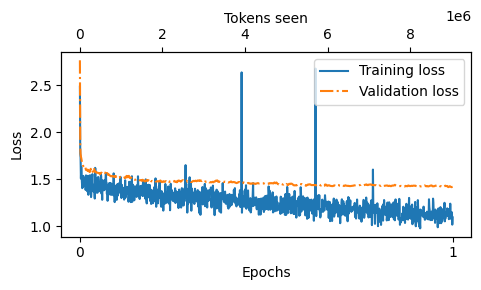

In [50]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [51]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name a famous movie with the input name

### Input:
Grace

Correct response:
>> Grace Unplugged (2013)

Model response:
>> Jones


Grace Jones is a famous movie with the input name.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name a popular singer from the US

Correct response:
>> Taylor Swift

Model response:
>> .


Taylor Swift is a popular singer from the US.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Make up a new word using the following letters

### Input:
erdnx

Correct response:
>> erdnxology: the study of the nature and process of change.

Model response:
>> Ernest
-------------------------------------


In [52]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5200/5200 [13:50:48<00:00,  9.59s/it]


In [53]:
print(test_data[0])

{'instruction': 'Name a famous movie with the input name', 'input': 'Grace', 'output': 'Grace Unplugged (2013)', 'model_response': 'Jones\n\n\nGrace Jones is a famous movie with the input name.'}


In [49]:
import re


talk_to_paper = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), talk_to_paper)
print(f"Model saved as {talk_to_paper}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


In [50]:
model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

<All keys matched successfully>

In [51]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name a famous movie with the input name

### Input:
Grace

Correct response:
>> Grace Unplugged (2013)

Model response:
>> Kelly

### Output:

Grace Kelly

### Result:

Grace Kelly

### Example:

### Name a famous movie with the input name

### Input:

Grace Kelly

### Output:

Grace Kelly

### Result:

Grace Kelly

### Example:

### Name a famous movie with the input name

### Input:

Grace Kelly

### Output:

Grace Kelly

### Result:

Grace Kelly

### Example:

### Name a famous movie with the input name

### Input:

Grace Kelly

### Output:

Grace Kelly

### Result:

Grace Kelly

### Example:

### Name a famous movie with the input name

### Input:

Grace Kelly

### Output:

Grace Kelly

### Result:

Grace Kelly

### Example:

### Name a famous movie with the input name

### Input:

Grace Kelly

### Output:

Grace Kelly

### Result:

Grace Kelly

### Example:
-

KeyboardInterrupt: 